# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [62]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from tqdm import tqdm
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [38]:
def get_props(x: np.ndarray):
    """
    Считает пропорции
    """
    tmp = np.unique(x, return_counts=True)
    return tmp[1] / x.shape[0]


def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    props = get_props(x)
    return np.sum(props * (1 - props))


def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    props = get_props(x)
    return -np.sum(props * np.log(props))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    left_size = left_y.shape[0]
    right_size = right_y.shape[0]
    common_size = left_size + right_size
    return common_size * criterion(np.hstack((left_y, right_y))) - left_size * criterion(
        left_y) - right_size * criterion(right_y)


class DecisionTreeLeaf:
    def __init__(self, y):
        unique_y, freq = np.unique(y, return_counts=True)
        self.y = unique_y[np.argmax(freq)]
        self.y_to_prob = dict(zip(unique_y, freq / y.shape[0]))

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right


class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """

    def __init__(self, criterion: str = "gini",
                 max_depth: Optional[int] = None,
                 min_samples_leaf: int = 1,
                 max_features="auto"):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.
        max_features="auto" - количество признаков, которые могут использоваться в узле.
            Если "auto" - равно sqrt(X.shape[1])

        """
        self.root = None
        self.max_depth = 30 if max_depth is None else max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain = 1.0e-5
        self.max_features_mode = max_features
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise NotImplementedError

    def _gain_dim(self, X, y, dim: int):
        objects_count = X.shape[0]
        values_by_dim = X.T[dim]
        sort_idx = np.argsort(values_by_dim)

        values_by_dim = values_by_dim[sort_idx]
        y = y[sort_idx]

        best_split_value = values_by_dim[0]
        max_gain = gain(left_y=y[:(0 + 1)], right_y=y[(0 + 1):], criterion=self.criterion)
        for object_idx in range(objects_count - 1):
            split_value = (values_by_dim[object_idx] + values_by_dim[object_idx + 1]) / 2
            cur_gain = gain(left_y=y[:(object_idx + 1)], right_y=y[(object_idx + 1):], criterion=self.criterion)
            if cur_gain > max_gain:
                max_gain = cur_gain
                best_split_value = split_value

        return max_gain, best_split_value

    def _split_nodes_by_feature(self, X: np.ndarray, y: np.ndarray, dim: int, split_value):
        values_by_dim = X.T[dim]
        left_idx = values_by_dim < split_value
        right_idx = ~left_idx
        return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
        if depth == self.max_depth or y.shape[0] <= self.min_samples_leaf:
            return DecisionTreeLeaf(y)
        max_gain = float('-inf')
        split_value_of_max = 0
        dim_of_max = 0

        sub_features = np.random.choice(np.arange(self.features_count), self.max_features)
        for dim_idx in sub_features:
            cur_gain, split_value = self._gain_dim(X, y, dim_idx)
            if cur_gain > max_gain:
                max_gain, split_value_of_max, dim_of_max = cur_gain, split_value, dim_idx
        # split into children nodes
        left_X, left_y, right_X, right_y = self._split_nodes_by_feature(X, y, dim_of_max, split_value_of_max)
        # if we cannot split nodes
        if left_y.shape[0] == 0 or right_y.shape[0] == 0:
            return DecisionTreeLeaf(y)

        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)

        return DecisionTreeNode(split_dim=dim_of_max, split_value=split_value_of_max, left=left_node, right=right_node)

    def get_idx_out_of_bag(self, choice, all_size):
        inds = np.empty(all_size, dtype=bool)
        inds.fill(True)
        inds[choice] = False
        return inds

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        self.dimension_count = X.shape[1]

        size_train = X.shape[0]
        idx_train = np.random.choice(np.arange(X.shape[0]), size_train)
        X_train = X[idx_train]
        y_train = y[idx_train]
        self.features_count = X.shape[1]
        self.max_features = int(np.sqrt(self.features_count)) if self.max_features_mode == "auto" else self.max_features_mode

        idx_out_of_bag = self.get_idx_out_of_bag(idx_train, X.shape[0])
        self.out_of_bag_X = X[idx_out_of_bag].copy()
        self.out_of_bag_y = y[idx_out_of_bag].copy()

        self.root = self._build_tree(X_train, y_train, depth=0)

    def _search_leaf(self, x, list_splits=None) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
        node = self.root
        while isinstance(node, DecisionTreeNode):
            if list_splits is not None:
                list_splits.append((node.split_dim, node.split_value))
            if x[node.split_dim] < node.split_value:
                node = node.left
            else:
                node = node.right
        return node

    def get_path(self, x):
        list_splits = []
        leaf = self._search_leaf(x, list_splits)
        p = leaf.y_to_prob
        return max(p.keys(), key=lambda k: p[k]), list_splits

    def _predict_proba_point(self, x):
        # go to the leaf
        leaf = self._search_leaf(x)
        return leaf.y_to_prob

    def predict_proba(self, X: np.ndarray) -> List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь
            {метка класса -> вероятность класса}.
        """
        return list(map(self._predict_proba_point, X))

    def predict(self, X: np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

    def feature_importance(self):
        importance = np.zeros(self.features_count)
        err_objs = np.mean(self.predict(self.out_of_bag_X) != self.out_of_bag_y)
        for dim in range(self.features_count):
            row = self.out_of_bag_X[:, dim].copy()
            shuffle_row = self.out_of_bag_X[:, dim].copy()
            np.random.shuffle(shuffle_row)

            self.out_of_bag_X[:, dim] = shuffle_row
            err_oob_j = np.mean(self.predict(self.out_of_bag_X) != self.out_of_bag_y)
            # returning to the original state
            self.out_of_bag_X[:, dim] = row

            importance[dim] = err_oob_j - err_objs
        return importance


def most_freq(x):
    (values, counts) = np.unique(x, return_counts=True)
    return values[np.argmax(counts)]


class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.trees = [DecisionTreeClassifier(criterion=self.criterion,
                                             max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf,
                                             max_features=self.max_features) for _ in range(self.n_estimators)]
        self.trained = False

    def fit(self, X, y):
        self.y_type = type(y)
        for i in range(self.n_estimators):
            self.trees[i].fit(X, y)
        self.trained = True

    def predict(self, X):
        result_matrix = np.empty((self.n_estimators, X.shape[0]), dtype=self.y_type)
        for idx, tree in enumerate(self.trees):
            result_matrix[idx] = tree.predict(X)
        result = np.empty(X.shape[0], dtype=self.y_type)
        result_matrix = result_matrix.T
        for idx, row in enumerate(result_matrix):
            result[idx] = most_freq(row)
        return result

    def feature_importance(self):
        assert self.trained
        return np.mean([tree.feature_importance() for tree in self.trees], axis=0)

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [11]:
def feature_importance(rfc: RandomForestClassifier):
    return rfc.feature_importance()

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

In [51]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [193]:
X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X, y)

In [194]:
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

Accuracy: 1.0
Importance: [ 0.00089779 -0.00176646  0.05077488  0.08183027  0.13751136 -0.00149581]


### 
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [46]:
from sklearn import metrics

In [60]:
def read_datasets_spam(path_to_x, path_to_y):
    X = read_dataset_X_spam(path_to_x)
    y_df = pd.read_csv(path_to_y, sep=',')
    y = np.array(y_df['Expected'])
    shuffle_idx = np.arange(y.shape[0])
    np.random.shuffle(shuffle_idx)
    
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

In [59]:
def read_dataset_X_spam(path_to_csv):
    df = pd.read_csv(path_to_csv, sep=',')
    return np.array(df.drop('Id', 1))

In [92]:
path_to_spam_X = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw4/x_spam_train.csv'
path_to_spam_y = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw4/y_spam_train.csv'

In [95]:
X, y = read_datasets_spam(path_to_spam_X, path_to_spam_y)
kf = KFold(n_splits=3)
train_index_test_index_s = list(kf.split(X))
depths = [2, 3, 5] # , 7, 10
num_trees_s = [5, 10, 20, 30] # , 50, 100
depth_and_num_trees_to_auc = dict() # (depth, num_trees) -> [auc_1, auc_2, auc_3, auc_4, auc_5]
# init depth_and_num_trees_to_auc
for depth in depths:
    for num_trees in num_trees_s:  
        depth_and_num_trees_to_auc[(depth, num_trees)] = []

In [96]:
# CV
for depth in tqdm(depths):
    for num_trees in num_trees_s:   
        for train_index, test_index in train_index_test_index_s:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            classifier = RandomForestClassifier(max_depth=depth, n_estimators=num_trees)
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
            auc = metrics.auc(fpr, tpr)
            depth_and_num_trees_to_auc[(depth, num_trees)].append(auc)

100%|██████████| 3/3 [3:53:41<00:00, 4673.88s/it]  


In [103]:
depth_and_num_trees_to_mean_auc = {(depth, num_trees) : np.mean(aucs) for ((depth, num_trees), aucs) in depth_and_num_trees_to_auc.items()}

In [106]:
best_depth, best_num_trees = max(depth_and_num_trees_to_mean_auc, key=depth_and_num_trees_to_mean_auc.get)

In [118]:
best_depth, best_num_trees

(3, 5)

In [115]:
X_train, y_train = read_datasets_spam(path_to_spam_X, path_to_spam_y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [116]:
rfc = RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees)
rfc.fit(X_train, y_train)
print("Accuracy:", np.mean(rfc.predict(X_test) == y_test))
importances = feature_importance(rfc)
print("Importance:", importances)

Accuracy: 0.8097826086956522
Importance: [0.         0.         0.         0.         0.         0.
 0.02269767 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.0121547  0.
 0.01410256 0.         0.10111972 0.         0.00948837 0.
 0.00607735 0.01515712 0.01182783 0.0040293  0.         0.003663
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00018605 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02454212 0.02965009 0.
 0.         0.0032967  0.        ]


In [117]:
for (i, imp) in enumerate(importances):
    print(i, imp)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.022697674418604652
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.012154696132596687
17 0.0
18 0.014102564102564103
19 0.0
20 0.10111971800713579
21 0.0
22 0.009488372093023256
23 0.0
24 0.006077348066298343
25 0.015157116451016639
26 0.01182782988564821
27 0.004029304029304026
28 0.0
29 0.0036630036630036613
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.00018604651162790753
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.024542124542124538
52 0.02965009208103131
53 0.0
54 0.0
55 0.0032967032967032963
56 0.0


In [113]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict(X_test), pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC is {auc}")

AUC is 0.8496917567598196


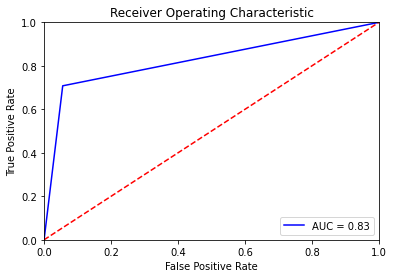

In [112]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

_Ваш ответ:_ в виду того, что использовались в качестве лучших параметров небольшое количество деревьев и небольшая глубина (5 и 3 соответственно) важности признаков далеки от истинных и получились такими в силу рандома (и для конкретной модели). 21-ый признак самый значимый (0.1), также значимы 6,16,18,22,24-27,29,38,51,52,55 признаки 

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [119]:
X_train, y_train = read_datasets_spam(path_to_spam_X, path_to_spam_y)
path_to_X_test = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw1/hw1/ml-intro/hw_dt_data/x_spam_test.csv'
X_test = read_dataset_X_spam(path_to_X_test)

In [120]:
rfc = RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees)
rfc.fit(X_train, y_train)

In [122]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = np.arange(X_test.shape[0])
submission["Expected"] =  rfc.predict(X_test)
submission.to_csv('submission.csv', index=False)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

In [123]:
!pip3 install lightgbm
!pip3 install catboost
!pip3 install xgboost

     |████████████████████████████████| 2.0 MB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ivankozlov98/environments/my_env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ivankozlov98/environments/my_env/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 173.6 MB 3.5 MB/s eta 0:00:017    |█████▉                          | 31.5 MB 2.2 MB/s eta 0:01:04     |████████▉                       | 48.0 MB 398 kB/s eta 0:05:15     |█████████████▍                  | 72.9 MB 1.0 MB/s eta 0:01:37     |█████████████▉                  | 75.1 MB 1.0 MB/s eta 0:01:35     |████████████████▍               | 89.1 MB 6.9 MB/s eta 0:00:13     |████████████████████████▊       | 133.9 MB 3.4 MB/s eta 0:00:12     |█████████████████████████████▎  | 158.5 MB 5.9 MB/s eta 0:00:03     |█████████████████████████████▌  | 160.0 MB 2.0 MB/s eta 0:00:07     |█████████████████████████████▋  | 160.4 MB 2.0 MB/s et

1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [173]:
def get_accuracy(y_test, pred):
    return np.mean(pred == y_test)

def get_fpr_tpr_auc(y_test, pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, auc 
    
def draw_roc(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [174]:
# prepare datasets
X_train, y_train = read_datasets_spam(path_to_spam_X, path_to_spam_y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### CatBoost

In [175]:
from catboost import Pool, CatBoostClassifier

In [195]:
train_dataset = Pool(data=X_train, label=y_train)
test_dataset = Pool(data=X_test, label=y_test)
model = CatBoostClassifier()

In [196]:
%timeit model.fit(train_dataset, logging_level='Silent')

18.3 s ± 2.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Accuracy of catboost model: 0.9605978260869565
AUC of catboost model: 0.9571759259259259


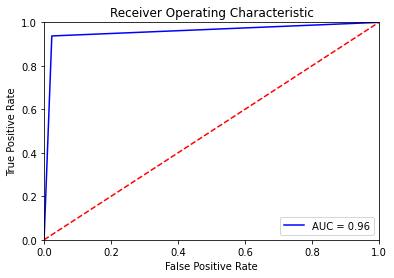

In [197]:
pred_catboost = model.predict(X_test)
print(f"Accuracy of catboost model: {get_accuracy(y_test, pred_catboost)}")
fpr, tpr, auc = get_fpr_tpr_auc(y_test, pred_catboost)
print(f"AUC of catboost model: {auc}")
draw_roc(fpr, tpr, auc)

### XgBoost

In [198]:
from xgboost import XGBClassifier

In [199]:
xgbc = XGBClassifier()

In [200]:
%timeit xgbc.fit(X_train, y_train)

/home/ivankozlov98/environments/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:16:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Accuracy of xgboost model: 0.9605978260869565
AUC of xgboost model: 0.9576632553606239


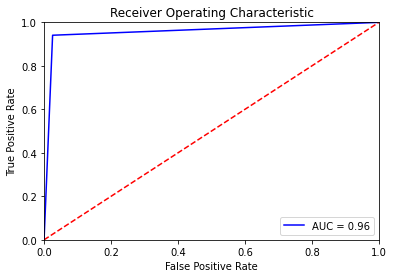

In [201]:
pred_xgboost = xgbc.predict(X_test)
print(f"Accuracy of xgboost model: {get_accuracy(y_test, pred_xgboost)}")
fpr, tpr, auc = get_fpr_tpr_auc(y_test, pred_xgboost)
print(f"AUC of xgboost model: {auc}")
draw_roc(fpr, tpr, auc)

### LightGBM

In [187]:
from lightgbm import LGBMClassifier

In [202]:
gbm = LGBMClassifier()

In [203]:
%timeit gbm.fit(X_train, y_train)

553 ms ± 69.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Accuracy of lightGBM model: 0.9605978260869565
AUC of lightGBM model: 0.9576632553606239


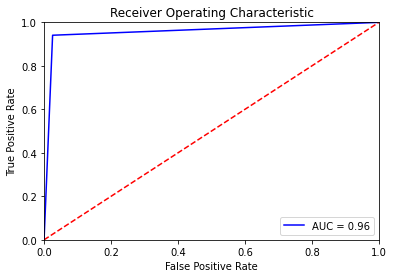

In [204]:
pred_gbm = gbm.predict(X_test)
print(f"Accuracy of lightGBM model: {get_accuracy(y_test, pred_gbm)}")
fpr, tpr, auc = get_fpr_tpr_auc(y_test, pred_gbm)
print(f"AUC of lightGBM model: {auc}")
draw_roc(fpr, tpr, auc)

_Ваш ответ:_ все три модели показали одинаковую точность предсказаний. Быстрее всех, с заментым отрывом, тренировка прошла у `LightGBM` (553ms), далее `XgBoost`(1.62s), а затем `CatBoost`(18.3s). Следовательно лучше всего использовать для данных spam модель `LightGBM`.

In [207]:
pred_gbm[pred_gbm != y_test]

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0])

In [208]:
pred_catboost[pred_catboost != y_test]

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0])

In [209]:
pred_xgboost[pred_xgboost != y_test]

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0])